In [7]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from pathlib import Path

from src.paths import project_dir
from src.datasets.volumetric_datasets import VolumeDatasetInMemory, PatchVolumeDatasetInMemory
from src.preprocessing.main_create_patched_phi_hit_dataset import interface_type_generator
from src.interface_representation.interface_types import InterfaceType
from src.plotting_utils import show_isosurface_plot_from_arr

from src.eval_utils import get_phi_sharp

logging.basicConfig(level=logging.INFO)

In [8]:
base_dir = Path('../../src/preprocessing')

In [9]:

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import skimage

interface_types = [
        InterfaceType.SIGNED_DISTANCE_EXACT,
        InterfaceType.SIGNED_DISTANCE_APPROXIMATE,
        InterfaceType.HEAVISIDE,
        InterfaceType.TANH_EPSILON,
    ]

epsilons = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]


def visualise_phi_sharp(arr, interface_type):
    arr = arr.squeeze()
    phi_sharp = get_phi_sharp(arr, interface_type)
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
    im = ax.imshow(phi_sharp[32, :, :])
    fig.colorbar(im, ax=ax)
    plt.show()
    plt.close()
    

def visualise_dataset_sample(arr):
    arr = arr.squeeze()
    assert arr.shape == (64, 64, 64)
    
    min_val, max_val = np.min(arr), np.max(arr)
    
    # Just one colorbar on right
    
    fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=200)
    im = axs[0].imshow(arr[32, :, :], vmin=min_val, vmax=max_val)
    axs[1].imshow(arr[:, 32, :], vmin=min_val, vmax=max_val)
    axs[2].imshow(arr[:, :, 32], vmin=min_val, vmax=max_val)
    
    # Add a colorbar to the right of the subplots
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    
    plt.show()
    plt.close()


def visualise_grad_magnitude(arr):
    dx = 1 / 256
    arr = arr.squeeze()
    grad = np.gradient(arr, dx)
    grad_magnitude = np.sqrt(np.sum(np.square(grad), axis=0))

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    im = axs[0].imshow(grad_magnitude[32, :, :])
    fig.colorbar(im, ax=axs[0])
    im = axs[1].imshow(grad_magnitude[:, 32, :])
    fig.colorbar(im, ax=axs[1])
    im = axs[2].imshow(grad_magnitude[:, :, 32])
    fig.colorbar(im, ax=axs[2])
    plt.show()
    plt.close()



def show_isosurface_plot_from_arr(vol: np.ndarray, N: float, level: float, verbose: bool) -> None:
    assert len(vol.shape) == 3
    assert vol.shape[0] == vol.shape[1] == vol.shape[2]

    fig = plt.figure(figsize=(6, 6), dpi=200)
    ax = fig.add_subplot(111, projection="3d")

    ax.set_xlim(0, N)
    ax.set_ylim(0, N)
    ax.set_zlim(0, N)

    verts, faces, normals, values = skimage.measure.marching_cubes(
        vol, level, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
    )

    while len(faces) > 500_000:
        faces = faces[::2]

    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor("k")
    mesh.set_linewidth(0.05)
    mesh.set_alpha(1.0)
    ax.add_collection3d(mesh)
    
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    plt.tight_layout()

    plt.show()
    plt.close(fig)
    
    
def visualise_surface_array(arrs, interface_type, outpath=None):
    if interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        level = 0.0
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT:
        level = 0.0
    else:
        level = 0.5
        
    assert len(arrs) == 3

    fig = plt.figure(figsize=(2, 6), dpi=200)
    
    for i in range(3):
        ax = fig.add_subplot(3, 1, i+1, projection="3d")
        ax.set_xlim(0, 64)
        ax.set_ylim(0, 64)
        ax.set_zlim(0, 64)
        
        verts, faces, normals, values = skimage.measure.marching_cubes(
            arrs[i].squeeze(), level, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner'
        )

        while len(faces) > 500_000:
            faces = faces[::2]

        mesh = Poly3DCollection(verts[faces])
        mesh.set_edgecolor((0, 0, 0, 0.2))  # RGBA: black, 20% opacity
        mesh.set_linewidth(0.05)
        mesh.set_alpha(0.5)
        ax.add_collection3d(mesh)

        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
    plt.tight_layout()

    if outpath is not None:
        plt.savefig(outpath)

    plt.show()
    
    
def visualise_surface(arr, interface_type):
    if interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        level = 0.0
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT:
        level = 0.0
    else:
        level = 0.5

    show_isosurface_plot_from_arr(arr.squeeze().numpy(), level=level, N=64, verbose=False)
    
def visualise_volume_fractions(dataset, interface_type):
    if not interface_type == InterfaceType.HEAVISIDE:
        return

    vol_fracs = []

    for i in range(len(dataset)):
        vol_fracs.append(np.sum(dataset[i].squeeze().numpy()) / dataset[i].numel())

    plt.hist(vol_fracs, bins=20)

def dataset_exploration(dataset, interface_type, epsilon):
    print(interface_type)
    ind = 0
    arr = dataset[ind]
    
    visualise_dataset_sample(arr)
    visualise_grad_magnitude(arr)
    visualise_surface(arr, interface_type)
    visualise_volume_fractions(dataset, interface_type)
    

def plot_surface_with_colormap_combined(arr, level=0.5, outpath=None):
    arr = arr.squeeze()
    fig = plt.figure(figsize=(3, 2.5), dpi=200)
    ax = fig.add_subplot(111, projection='3d')

    # 3D surface plot
    ax.set_xlim(0, arr.shape[0])
    ax.set_ylim(0, arr.shape[1])
    ax.set_zlim(0, arr.shape[2])

    verts, faces, normals, values = skimage.measure.marching_cubes(arr, level, spacing=(1, 1, 1), allow_degenerate=False, method='lewiner')
    
    # Filter faces where all vertices have y <= 32
    y_threshold = 32
    valid_faces = []  # List to store valid faces
    for face in faces:
        # Check if all vertices in the face have y <= 32
        if all(verts[vertex][1] <= y_threshold for vertex in face):
            valid_faces.append(face)

    # Convert valid_faces to a numpy array
    valid_faces = np.array(valid_faces)

    # Create the mesh using only the valid faces
    mesh = Poly3DCollection(verts[valid_faces])
    #mesh = Poly3DCollection(verts[faces])
    
    mesh.set_edgecolor((0, 0, 0, 0.2))  # RGBA: black, 50% opacity
    mesh.set_linewidth(0.01)
    mesh.set_alpha(0.5)
    ax.add_collection3d(mesh)

    # Color map in the y=32 plane
    y_plane_index = 32  # Use y=32 as the plane
    y_plane = arr[:, y_plane_index, :]  # Extract the 2D slice along y=32
    x, z = np.meshgrid(np.arange(y_plane.shape[0]), np.arange(y_plane.shape[1]))

    # Plot the contour map in the x-z plane at y=32
    ax.contourf(x, y_plane.T, z, zdir='y', offset=y_plane_index, cmap='viridis', alpha=1, levels=10)

    # Add colorbar
    mappable = plt.cm.ScalarMappable(cmap='viridis')
    mappable.set_array(y_plane)
    fig.colorbar(mappable, ax=ax, orientation='vertical', fraction=0.04, pad=0.04)

    # Remove axis labels
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    plt.tight_layout()

    if outpath is not None:
        plt.savefig(outpath)

    plt.show()
    plt.close(fig)


InterfaceType.SIGNED_DISTANCE_EXACT


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in ../../src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=4000, val=1000
INFO:src.datasets.volumetric_datasets:Loaded 1000 files for split val
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-03-22-12-49-Folder_120_Restart_007_1.01164_patch_10.npz
INFO:src.datasets.volumetric_datasets:Generated 1000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])


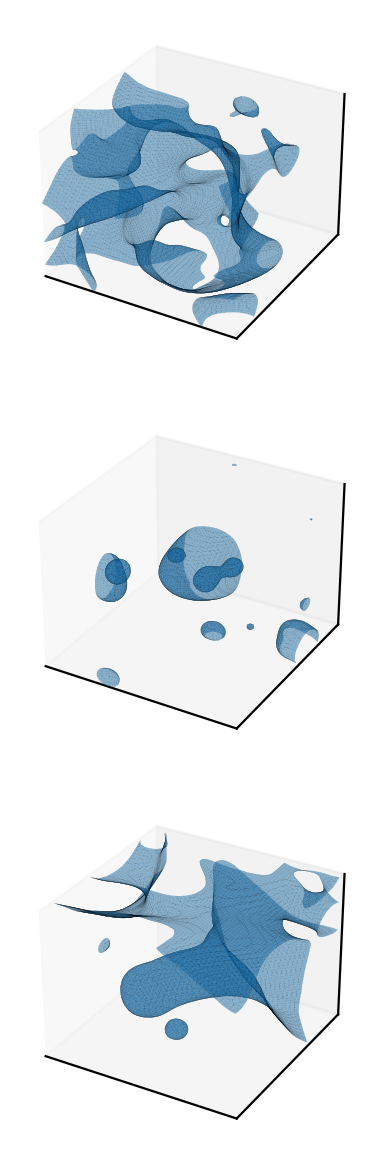

In [15]:
# Create a 3x3 array of samples from the dataset, plot surface

for interface_type, epsilon, outdir in interface_type_generator(interface_types, epsilons):
    
    print(interface_type)
    
    dataset = VolumeDatasetInMemory(data_dir=base_dir / outdir, split='val', debug=False, data_key='phi', metadata_keys=None, max_num_samples=5_000)

    #np.random.seed(42)
    #inds = np.random.choice(len(dataset), 3)
    #print(inds)
    inds = [435, 100, 600]
    arrs = [dataset[i].numpy() for i in inds]

    outpath = Path('output') / "HIT_samples.pdf"
    visualise_surface_array(arrs, interface_type, outpath=outpath)

    break


InterfaceType.SIGNED_DISTANCE_EXACT


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in ../../src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=4000, val=1000
INFO:src.datasets.volumetric_datasets:Loaded 1000 files for split val
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_EXACT/2023-03-22-12-49-Folder_120_Restart_007_1.01164_patch_10.npz
INFO:src.datasets.volumetric_datasets:Generated 1000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])


output/SIGNED_DISTANCE_EXACTNone_645.pdf


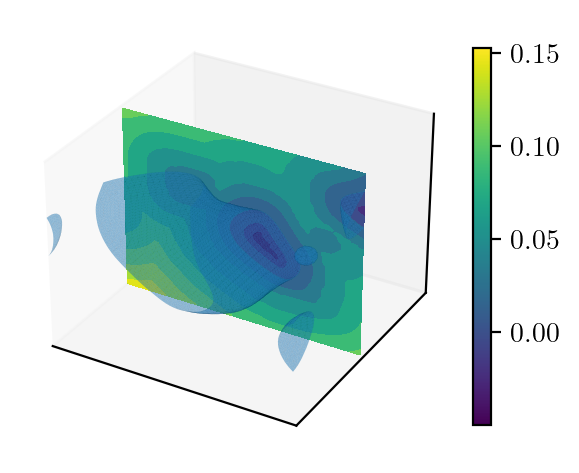

InterfaceType.SIGNED_DISTANCE_APPROXIMATE


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in ../../src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_APPROXIMATE
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_APPROXIMATE/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=4000, val=1000
INFO:src.datasets.volumetric_datasets:Loaded 1000 files for split val
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/SIGNED_DISTANCE_APPROXIMATE/2023-03-22-12-49-Folder_120_Restart_007_1.01164_patch_10.npz
INFO:src.datasets.volumetric_datasets:Generated 1000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])


output/SIGNED_DISTANCE_APPROXIMATENone_645.pdf


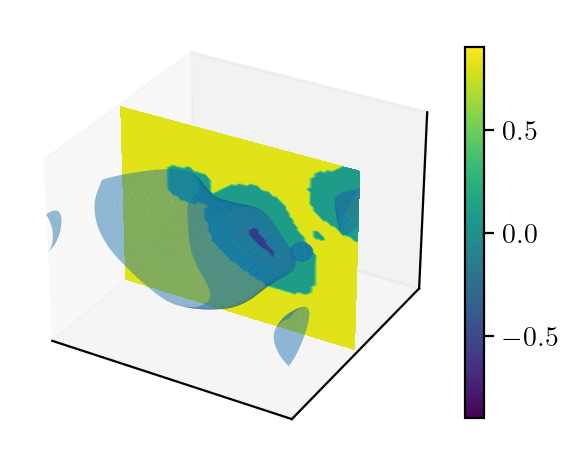

InterfaceType.HEAVISIDE


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in ../../src/preprocessing/data/patched_hit_experiment/HEAVISIDE
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/HEAVISIDE/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=4000, val=1000
INFO:src.datasets.volumetric_datasets:Loaded 1000 files for split val
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/HEAVISIDE/2023-03-22-12-49-Folder_120_Restart_007_1.01164_patch_10.npz
INFO:src.datasets.volumetric_datasets:Generated 1000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])


output/HEAVISIDENone_645.pdf


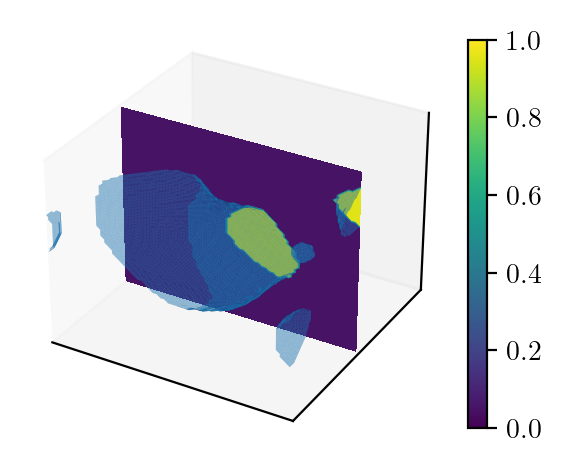

InterfaceType.TANH_EPSILON


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=4000, val=1000
INFO:src.datasets.volumetric_datasets:Loaded 1000 files for split val
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0078125/2023-03-22-12-49-Folder_120_Restart_007_1.01164_patch_10.npz
INFO:src.datasets.volumetric_datasets:Generated 1000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])


output/TANH_EPSILON0.0078125_645.pdf


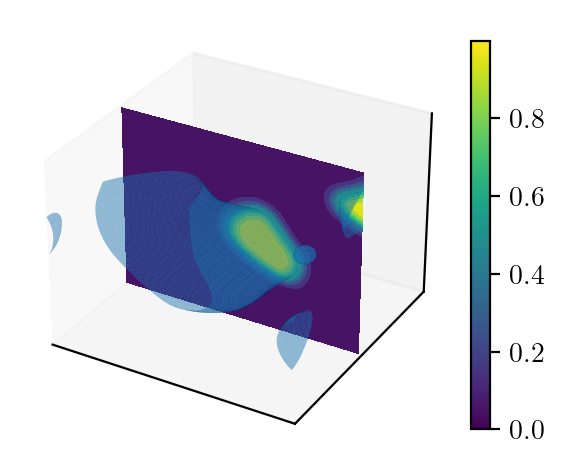

InterfaceType.TANH_EPSILON


INFO:src.datasets.volumetric_datasets:Found 59410 .npz files in ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.015625
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.015625/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=4000, val=1000
INFO:src.datasets.volumetric_datasets:Loaded 1000 files for split val
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.015625/2023-03-22-12-49-Folder_120_Restart_007_1.01164_patch_10.npz
INFO:src.datasets.volumetric_datasets:Generated 1000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])


output/TANH_EPSILON0.015625_645.pdf


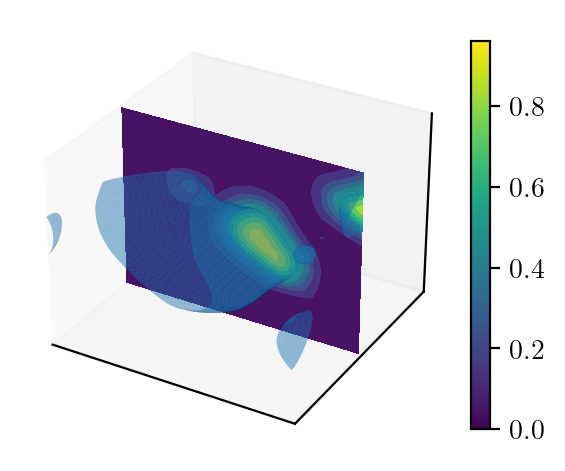

InterfaceType.TANH_EPSILON


INFO:src.datasets.volumetric_datasets:Found 59408 .npz files in ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=4000, val=1000
INFO:src.datasets.volumetric_datasets:Loaded 1000 files for split val
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.03125/2023-03-22-12-49-Folder_120_Restart_007_1.01164_patch_10.npz
INFO:src.datasets.volumetric_datasets:Generated 1000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])


output/TANH_EPSILON0.03125_645.pdf


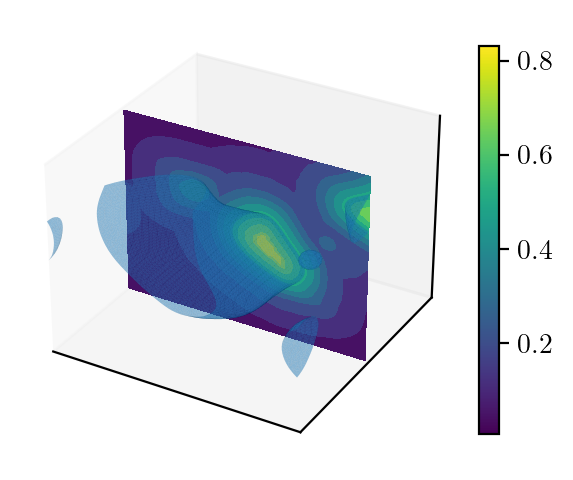

InterfaceType.TANH_EPSILON


INFO:src.datasets.volumetric_datasets:Found 59406 .npz files in ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0625
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0625/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=4000, val=1000
INFO:src.datasets.volumetric_datasets:Loaded 1000 files for split val
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.0625/2023-03-22-12-49-Folder_120_Restart_007_1.01164_patch_10.npz
INFO:src.datasets.volumetric_datasets:Generated 1000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])


output/TANH_EPSILON0.0625_645.pdf


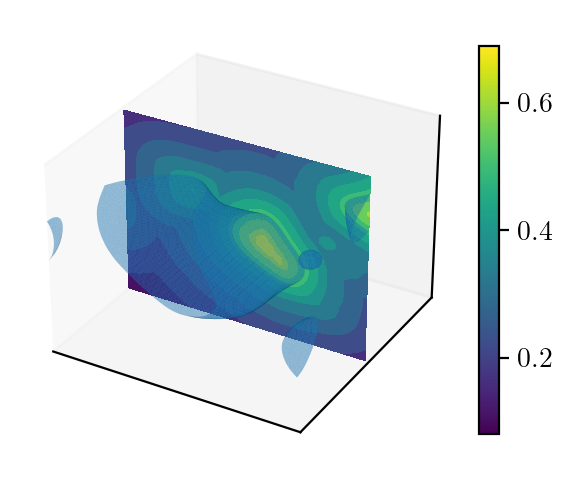

InterfaceType.TANH_EPSILON


INFO:src.datasets.volumetric_datasets:Found 59400 .npz files in ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=4000, val=1000
INFO:src.datasets.volumetric_datasets:Loaded 1000 files for split val
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.125/2023-03-22-12-49-Folder_120_Restart_007_1.01164_patch_10.npz
INFO:src.datasets.volumetric_datasets:Generated 1000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])


output/TANH_EPSILON0.125_645.pdf


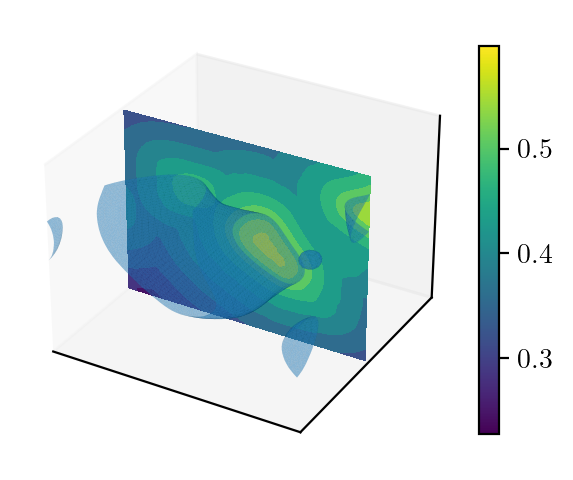

InterfaceType.TANH_EPSILON


INFO:src.datasets.volumetric_datasets:Found 59388 .npz files in ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25/2023-03-22-12-49-Folder_101_Restart_000_0_patch_1.npz
INFO:src.datasets.volumetric_datasets:Constructed splits of size: train=4000, val=1000
INFO:src.datasets.volumetric_datasets:Loaded 1000 files for split val
INFO:src.datasets.volumetric_datasets:First file: ../../src/preprocessing/data/patched_hit_experiment/TANH_EPSILON0.25/2023-03-22-12-49-Folder_120_Restart_007_1.01164_patch_11.npz
INFO:src.datasets.volumetric_datasets:Generated 1000 samples of volumetric data
INFO:src.datasets.volumetric_datasets:Each sample has shape torch.Size([1, 64, 64, 64])


output/TANH_EPSILON0.25_645.pdf


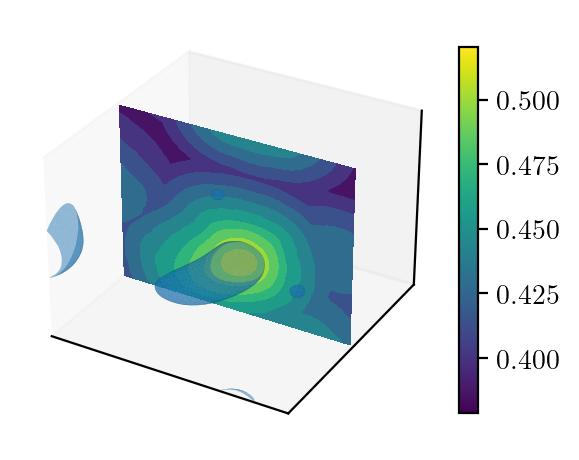

In [11]:
# For a random selection of inds, check that each val dataset GT is exactly the same

for interface_type, epsilon, outdir in interface_type_generator(interface_types, epsilons):
    
    print(interface_type)
    
    dataset = VolumeDatasetInMemory(data_dir=base_dir / outdir, split='val', debug=False, data_key='phi', metadata_keys=None, max_num_samples=5_000)
    
    for i in [645]:
        arr = dataset[i].numpy()

        # Set level based on interface_type
        if interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
            level = 0.0
        elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT:
            level = 0.0
        else:
            level = 0.5

        outpath = f"output/{interface_type.name}{epsilon}_{i}.pdf"
        print(outpath)
            
        plot_surface_with_colormap_combined(arr, level, outpath)
        
        